![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)

# Exploring Fire Burned Area products available through the C3S

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-land/develop?labpath=fire-burned-area.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/develop/fire-burned-area.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/develop/fire-burned-area.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-land/blob/develop/fire-burned-area.ipynb)

## Learning objectives 🎯

At the end of this notebook, the user will be able to:

- Use WeKEO to explore Fire Burned Area products available through the C3S;
- Retrieve data on Burned Area from the C3S Climate Data Store, examining, subsetting, saving and re-projecting it using Python code;
- Create a time series of Burned Area information using the product;
- Generate informative maps of burned area estimates, at a continental scale.


The Burned Area products provide global information of total burned area (BA) at pixel and grid scale. The BA is identified with the date of first detection of the burned signal in the case of the pixel product, and with the total BA per grid cell in the case of the grid product. The products were obtained through the analysis of reflectance changes from medium resolution sensors (Terra MODIS, Sentinel-3 OLCI), supported by the use of MODIS thermal information. The burned area products also include information related to the land cover that has been burned, which has been extracted from the Climate Change Initiative (CCI) and Copernicus Climate Change Service (C3S) land cover datasets, thus assuring consistency between the datasets. (v5.1.1.cds uses the LC_cci dataset).

The algorithms for BA retrieval were developed by the University of Alcala (Spain), and processed by Brockmann Consult GmbH (Germany). Different product versions are available. FireCCI v5.0cds and FireCCI v5.1cds were developed as part of the Fire ECV Climate Change Initiative Project (Fire CCI) and brokered to C3S, offering the first global burned area time series at 250m spatial resolution. FireCCI v5.1cds used a more mature algorithm than the previous version 5.0cds, which has been deprecated. This algorithm was adapted to Sentinel-3 OLCI data to create the C3S v1.0 burned area product, extending the BA database to the present.

The BA products are useful for researchers studying climate change, as they provide crucial information on burned biomass, which can be translated to greenhouse gases emissions amongst other contaminants. Burned area is also useful for land cover change studies, fire management and risk analysis.

![logo](./img/overview_BA.png)



**Figure 1: Map of the day of first detection from the Pixel Burned Area product of December 2016**

## Prepare your environment

### Set up CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [1]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

The Jupyter Notebook must be set up with all the necessary available tools from the Jupyter Notebook ecosystem. Make sure to have all the necessary libraries already pre-installed. Here is the list of the modules we will be using in this exercise.

| Module name | Description |
| :---: | :---|
| **numpy** | [NumPy](https://numpy.org/) is the fundamental package for scientific computing with Python and for managing ND-arrays. |
|**rasterio**|[Rasterio](https://rasterio.readthedocs.io/en/stable/) is a library that allows operations on gridded raster data such as satellite images or terrain models.|
| **xarray** | [Xarray](http://xarray.pydata.org/en/stable/) is a very user friendly library to manipulate NetCDF files within Python. It introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. |
| **matplotlib** |[Matplotlib](https://matplotlib.org/) is a Python 2D plotting library which produces high quality figures. |
| **cartopy** |[Cartopy](https://scitools.org.uk/cartopy/docs/latest/) is a library for plotting maps and geospatial data analyses in Python. |
|**geopandas**|[Geopandas](https://geopandas.org/en/stable/) is a library that allows spatial operation on geometric data.|

In [ ]:
# Modules system
# import warnings
# warnings.filterwarnings('ignore')
import os

# Modules related to data retrieving
import earthkit as ek
import cdsapi
# import json

# Modules related to plot and EO data manipulation
import numpy as np
# import xarray as xr
# import matplotlib
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from matplotlib.colors import LogNorm
# import cartopy
import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import pandas as pd
# import geopandas as gpd
# from shapely.geometry import box, Polygon, MultiPolygon
# from fiona.crs import from_epsg

# import rasterio
# from rasterio.mask import mask

### Specify data directory

Below we define a directory to store the files locally, and create this directory if it does not already exist

In [ ]:
# Directory to store data
# Please ensure that data_dir is a location where you have write permissions
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

## Explore data

The data used in the examples are the satellite-based Fire Burned Area products that provide global information of total burned area (BA) at pixel and grid scale.

For documentation and other information on Fire Burned Area available through the CDS, please visit the CDS [Fire Burned Area](https://cds.climate.copernicus.eu/datasets/satellite-fire-burned-area?tab=overview) page.


:::{note}

During July 2020, an error in some files in the version v5.1cds were identified, affecting the files of the grid product of January 2018, and the pixel and grid products of October, November and December 2019. These errors were fixed, and a new version, v5.1.1cds, was created for the whole time series, to replace version v5.1cds. The latter product has been deprecated, but it is temporally kept in the database for transparency and traceability reasons. Only version v5.1.1cds should be used.

:::


The [C3S Fire BA dataset](https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3ASATELLITE_FIRE_BURNED_AREA) comprises maps of global burned area developed and tailored for use by climate, vegetation and atmospheric modellers, as well as by fire researchers or fire managers interested in historical burned patterns. The dataset is comprised of two Burned Area products at different spatial resolutions, the Pixel product, at the original resolution of the sensor (MODIS or OLCI), and the Grid product, at 0.25-degree resolution. 

Both products are provided in NetCDF format, and while the Grid product is comprised of one global file, the Pixel product is divided in six continental subsets. All data are provided in monthly files. The main variable in the Pixel product is the day of detection of the fire, with two additional attributes corresponding to the confidence level and the land cover burned. In the case of the Grid product, the main variable is the sum of surface burned area in each grid cell, with ancillary attributes corresponding to the standard error, the fraction of burnable area, the fraction of observed area, and the total BA for each land cover types.

:::{dropdown} **Table 1: Data description**
                             
|   DATA  | DESCRIPTION|
| :---: | :---:|                                                                                                                                                                  
|**Data type** | Gridded|
|**Projection** |	Plate Carrée|
|**Horizontal coverage** | 	Grid product: Global <br> Pixel product: Continents |
|**Horizontal resolution** |Grid product: 0.25° latitude x 0.25° longitude <br> Pixel product: 250m (v5.1.1cds); 300m (v1.1)|
|**Vertical coverage** | Surface|
|**Vertical resolution** | Single level|
|**Temporal coverage** | 	From 2001 to 2019 for v5.1.1cds <br> From 2017 to present for v1.1|
|**Temporal resolution** | 	Grid product: 1 month (v5.1.1cds and v1.1) <br> Pixel product: Daily detections in a Monthly file|
|**File format**	| NetCDF4|
|**Conventions**	| Climate and Forecast (CF) Metadata Convention v1.6 and ESA CCI Data Standards [DSWG 2015]|
|**Versions**	| 	Versions v5.1.1cds provide data from the European Space Agency Climate Change Initiative <br> Version 1.1 is the first burned area product developed especifically for the Copernicus Climate Change Service.<br> Versions v5.0cds, v5.1cds and v1.0 have been deprecated, and replaced by versions v5.1.1cds and v1.1, respectively. <br> Versions v5.0cde, v5.1cds and v1.0 are kept for traceability, transparency and reproducibility.<br> All versions are produced with the same processing chain.|
|**Update frequency**	| Yearly|

:::

:::{dropdown} **Table 2: Main variables**

| |MAIN VARIABLES||
| :---: | :---:|  :---:|         
|**Name** |	Units | Description | 
|**Burned area (Grid product)** |	m² | Total burned area within each pixel in the  monthly period. | 
|**Burned area in vegetation class (Grid product)** |	m² | Sum of burned area by land cover classes; land cover classes are from CCI Land Cover (for version 5.1.1cds) or C3S Land Cover (for version v1.1).| 
|**Confidence level (Pixel product)** |	% | 	Probability of detecting a pixel as burned. Possible values: 0 when the pixel is not observed in the month, or it is not burnable; 1 to 100 probability values when the pixel was observed. The closer to 100, the higher the confidence that the pixel is actually burned.| 
|**Flag of pixel detection (Pixel product)** |	Dimensionless | Day in which the fire was first detected. Possible values: 0 if the pixel is not burned; 1 to 366 day of the first detection when the pixel is burned; -1 when the pixel is not observed in the month; -2 when pixel is not burnable: water bodies, bare areas, urban areas and permanent snow and ice. | 
|**Fraction of burnable area (Grid product)** |	Dimensionless |The fraction of burnable area is the fraction of the cell that corresponds to vegetated land covers that could burn. The land cover classes are those from CCI Land Cover for version 5.0cds or C3S Land Cover for the rest of the versions.  | 
|**Fraction of observed area (Grid product)** |	Dimensionless |The fraction of the total burnable area in the cell that was observed during the time interval and was not marked as unsuitable/not observable. The latter refers to the area where it was not possible to obtain observational burned area information for the whole time interval because of lack of input data (non-existing images for that location and period), cloud cover, haze or pixels that fell below the quality thresholds of the algorithm.  | 
|**Land cover of burned pixels (Pixel product)** |	Dimensionless | 	Land cover of the burned pixel, extracted from the CCI LandCover v1.6.1 for version 5.0cds or C3S Land Cover for the rest of the versions. Possible values: 0 when the pixel is not burned in the month, either because it was observed and not classified as burned, or because it is non burnable or was not observed; 10 to 180: land cover code when the pixel is burned  | 
|**Standard error (Grid product)** |	m² | Error on the estimation of burned area in each grid cell, based on the aggregation of the confidence level of the pixel product. | 

:::


### Download the data


There are different ways to download data in the [Climate Data Store](https://cds.climate.copernicus.eu). You can do it manually from the [Download tab](https://cds.climate.copernicus.eu/datasets/satellite-fire-burned-area?tab=download), or you can download the data using the CDS-API as we do in this notebook. To write a new request, the easiest way is to select your data parameters on the [Download tab](https://cds.climate.copernicus.eu/datasets/satellite-fire-burned-area?tab=download), then click on **"Show API request"**, and copy/paste it in a file (or directly in a notebook cell).

:::{warning}

Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form.

:::

First we will connect our cdsapi client


In [4]:
c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)

2025-04-08 14:19:43,493 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-08 14:19:43,494 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


**Fire BA grid product April 2022**

In [ ]:
# Define a download filename:
download_filename_gridded = f"{DATADIR}/ba_grid_04_2022.zip"

# Downloading ba-pixel product over Europe
dataset = "satellite-fire-burned-area"
request = {
    "origin": "c3s",
    "sensor": "olci",
    "variable": "grid_variables",
    "version": "1_1",
    "year": ["2022"],
    "month": ["04"],
    "nominal_day": ["01"]
}

if not os.path.exists(download_filename_gridded):
    c.retrieve(dataset, request, download_filename_gridded)
else:
    print(f"File {download_filename_gridded} already exists. Skipping download.")

ba_grid_data = ek.data.from_source("file", download_filename_gridded)
ba_grid_data


File ./data_dir/ba_grid_04_2022.zip already exists. Skipping download.


NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-defb1cd011b4ed44b9407da2178fd39b80f53bcbf0264d35b77b94202420fbbe.d/20220401-C3S-L4_FIRE-BA-OLCI-fv1.1.nc)

**Fire BA pixel product April 2022 over Europe**

In [ ]:
# Define a download filename:
download_filename_pixel = f"{DATADIR}/ba_pixel_04_2022.zip"

# Downloading ba-pixel product over Europe
dataset = "satellite-fire-burned-area"
request = {
    "origin": "c3s",
    "sensor": "olci",
    "variable": "pixel_variables",
    "version": "1_1",
    "region": ["europe"],
    "year": ["2022"],
    "month": ["04"],
    "nominal_day": ["01"]
}

if not os.path.exists(download_filename_pixel):
    c.retrieve(dataset, request, download_filename_pixel)
else:
    print(f"File {download_filename_pixel} already exists. Skipping download.")

ba_pixel_data = ek.data.from_source("file", download_filename_pixel)

ba_pixel_data


File ./data_dir/ba_pixel_04_2022.zip already exists. Skipping download.


NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-c333d36ffcc5ebea6e357158938944ac81277180ff942bc4cf6b371613c511f4.d/20220401-C3S-L3S_FIRE-BA-OLCI-AREA_3-fv1.1.nc)

## Visualise the C3S & CCI Fire Burned Area dataset

The C3S & CCI Fire Burned Area products provide global information of total burned area (BA) at pixel and grid scale. For visualization of these products — whether using the pixel or grid product — the following key steps can be applied:

**Application main steps:**
- Definition of the color map
- (Define a subset based on the latitude and longitude values)
- Compose a title
- Show the result on a map using the chosen title
- Save the subset and the image

### The Fire Burned Area gridded product

Let's take a first quick look at the dataset! Let's plot for example April of the year 2022!

In [7]:

cmap = mcolors.ListedColormap([
    ( 49/256.,  57/256., 149/256.),    # <1         # <5
    ( 57/256.,  94/256., 196/256.),    # 1-5        # 5-10
    ( 96/256., 143/256., 204/256.),    # 5-10       # 10-25
    (171/256., 217/256., 233/256.),    # 10-25      # 25-50
    (255/256., 255/256., 191/256.),    # 25-50      # 50-100
    (253/256., 174/256.,  97/256.),    # 50-100     # 100-250
    (215/256.,  48/256.,  39/256.),    # 100-200    # 250-500
    (165/256.,   0/256.,  38/256.),    # 200-300    # 500-750
    (135/256.,   0/256.,   0/256.),    # >300       # >750
])

bounds = [0.5, 5, 50, 100, 250, 500, 1000, 1500, 2500, 5000]
norm = mcolors.BoundaryNorm(bounds, cmap.N) 

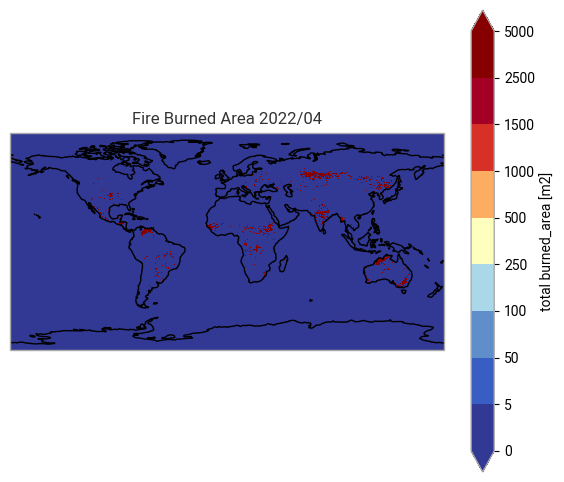

In [8]:
data_ba_grid=ba_grid_data.to_xarray()
data_ba_grid_2D=data_ba_grid['burned_area']

# Set plot title
time_0= data_ba_grid_2D['time'].values[0]
time_str = pd.to_datetime(time_0).strftime('%Y/%m')
title = 'Fire Burned Area ' + time_str

# Create the figure
ax = plt.axes(projection=ccrs.PlateCarree())
data_ba_grid_2D[0].plot(cmap=cmap, norm=norm, ax=ax)
ax.coastlines()
ax.set_title(title)

#show figure
plt.show()

**Figure 2: Fire Burned Area map of April 2022**

Define a subset based on the latitude and longitude values

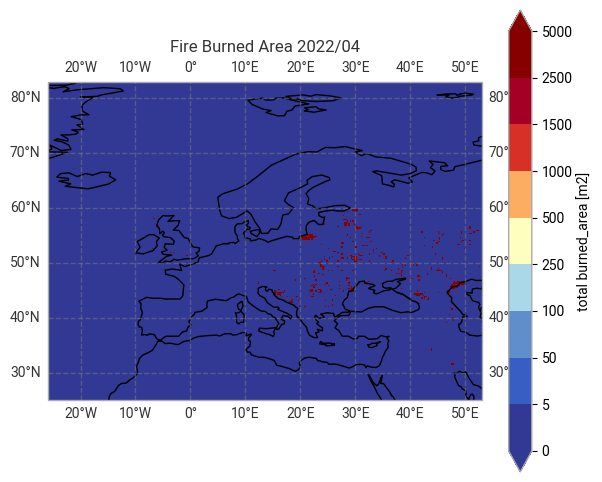

In [9]:
# Spatial subset selection 
min_lon = -26
min_lat = 83
max_lon = 53
max_lat =25

data_subset_ba_grid = data_ba_grid.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
data_subset_ba_grid_2D=data_subset_ba_grid['burned_area']

# Set plot title
time_0= data_subset_ba_grid_2D['time'].values[0]
time_str = pd.to_datetime(time_0).strftime('%Y/%m')
title_subset = 'Fire Burned Area ' + time_str

# Create the figure
ax = plt.axes(projection=ccrs.PlateCarree())
fig=data_subset_ba_grid_2D[0].plot(cmap=cmap, norm=norm)
gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top=False
ax.coastlines()
plt.title(title)
plt.show()


**Figure 3: Fire Burned Area map of April 2022 in Europe**

In [ ]:
# Show the complete dataset
data_ba_grid

<xarray.Dataset> Size: 91MB
Dimensions:                          (lat: 720, bounds: 2, lon: 1440, time: 1,
                                      vegetation_class: 18)
Coordinates:
  * lat                              (lat) float32 3kB 89.88 89.62 ... -89.88
  * lon                              (lon) float32 6kB -179.9 -179.6 ... 179.9
  * time                             (time) datetime64[ns] 8B 2022-04-01
  * vegetation_class                 (vegetation_class) int32 72B 10 20 ... 180
Dimensions without coordinates: bounds
Data variables:
    lat_bounds                       (lat, bounds) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    lon_bounds                       (lon, bounds) float32 12kB dask.array<chunksize=(1440, 2), meta=np.ndarray>
    time_bounds                      (time, bounds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    vegetation_class_name            (vegetation_class) |S150 3kB dask.array<chunksize=(18,), meta=np.ndarray>
    burned_area                      (time, lat, lon) float32 4MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    standard_error                   (time, lat, lon) float32 4MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    fraction_of_burnable_area        (time, lat, lon) float32 4MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    fraction_of_observed_area        (time, lat, lon) float32 4MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    burned_area_in_vegetation_class  (time, vegetation_class, lat, lon) float32 75MB dask.array<chunksize=(1, 18, 720, 1440), meta=np.ndarray>
    crs                              int32 4B ...
Attributes: (12/40)
    title:                      ECMWF C3S Gridded OLCI Burned Area product
    institution:                University of Alcala
    source:                     ESA Sentinel-3 A+B OLCI FR, MODIS MCD14ML Col...
    history:                    Created on 2022-11-12 06:36:15
    references:                 See https://climate.copernicus.eu/
    tracking_id:                842603aa-9703-42ea-8db0-b8f553ae5c6f
    ...                         ...
    sensor:                     OLCI
    spatial_resolution:         0.25 degrees
    geospatial_lon_units:       degrees_east
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.25
    geospatial_lat_resolution:  0.25

In [ ]:
# Show the subset of the dataset regarding the variable
data_ba_grid_2D

<xarray.DataArray 'burned_area' (time: 1, lat: 720, lon: 1440)> Size: 4MB
dask.array<open_dataset-burned_area, shape=(1, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 8B 2022-04-01
Attributes:
    units:          m2
    standard_name:  burned_area
    long_name:      total burned_area
    cell_methods:   time: sum

In [ ]:
# Show the subset of the dataset regarding the variable and spatial content 
data_subset_ba_grid_2D

<xarray.DataArray 'burned_area' (time: 1, lat: 232, lon: 316)> Size: 293kB
dask.array<getitem, shape=(1, 232, 316), dtype=float32, chunksize=(1, 232, 316), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 928B 82.88 82.62 82.38 82.12 ... 25.62 25.38 25.12
  * lon      (lon) float32 1kB -25.88 -25.62 -25.38 -25.12 ... 52.38 52.62 52.88
  * time     (time) datetime64[ns] 8B 2022-04-01
Attributes:
    units:          m2
    standard_name:  burned_area
    long_name:      total burned_area
    cell_methods:   time: sum

#### Write dataset contents to a netCDF file

In [ ]:
data_subset_ba_grid_2D.to_netcdf(
    path=os.path.join(DATADIR, "ba_042022_europe_grid.nc"),
)

#### Re-project the data into another projection

Let's visualise the April of the year 2022 once again, but in a different projection!

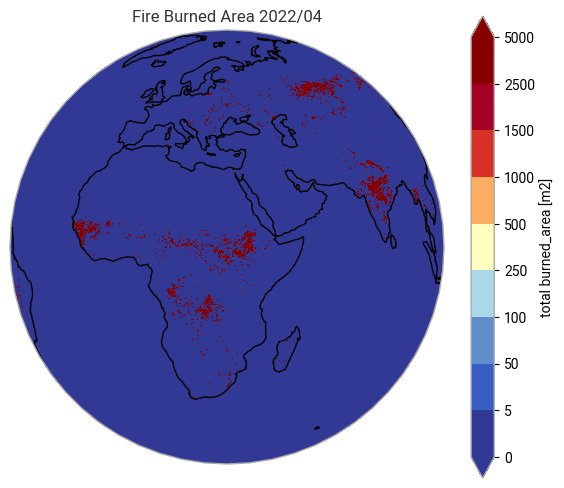

In [14]:
ax = plt.axes(projection=ccrs.Orthographic(30, 10))
ax.set_global()
data_ba_grid_2D[0].plot(ax=ax, transform=ccrs.PlateCarree(),cmap=cmap, norm=norm )
ax.coastlines()
plt.title(title)
plt.show()

**Figure 4: Fire Burned Area map of April 2022 - orthographic projection**

### The Fire Burned Area pixel product

Let's take a first quick look at the dataset! Let's plot for example April of the year 2022 over SE-Europe!

In [15]:
cmap = mcolors.ListedColormap([
    ( 49/256.,  57/256., 149/256.),    # <1         # <5
    ( 57/256.,  94/256., 196/256.),    # 1-5        # 5-10
    ( 96/256., 143/256., 204/256.),    # 5-10       # 10-25
    (171/256., 217/256., 233/256.),    # 10-25      # 25-50
    (255/256., 255/256., 191/256.),    # 25-50      # 50-100
    (253/256., 174/256.,  97/256.),    # 50-100     # 100-250
    (215/256.,  48/256.,  39/256.),    # 100-200    # 250-500
    (165/256.,   0/256.,  38/256.),    # 200-300    # 500-750
    (135/256.,   0/256.,   0/256.),    # >300       # >750
])

bounds = [-2, -1, 0, 1, 25, 50, 100, 200, 300, 365]
norm = mcolors.BoundaryNorm(bounds, cmap.N) 

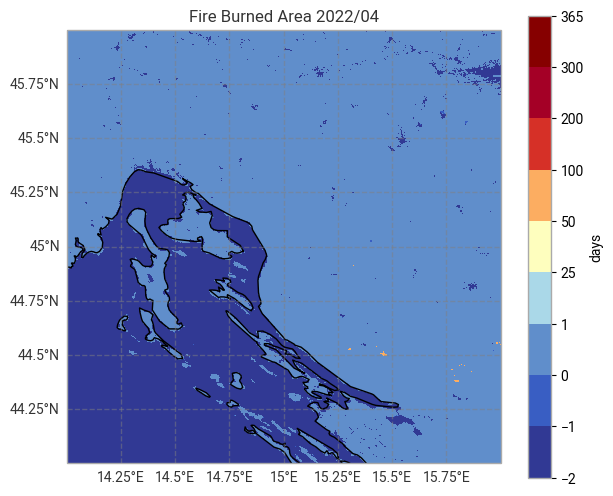

In [ ]:
# Spatial subset selection 
min_lon = 10
min_lat = 48
max_lon = 20
max_lat = 42

data_ba_pixel=ba_pixel_data.to_xarray()
#data_ba_pixel=ba_pixel_data.to_xarray(xarray_open_mfdataset_kwargs=dict(decode_cf=False, decode_times=False)
data_subset_ba_pixel = data_ba_pixel.sel(
    lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon)
)

str_first_day_of_obs_year= str(data_subset_ba_pixel.coords['time'].values[0]).split('-')[-3] + '-01-01T00:00:00.000'
data_subset_ba_pixel_2D = (data_subset_ba_pixel['JD']-np.datetime64(str_first_day_of_obs_year)).dt.days

# Set plot title
time_0= data_subset_ba_pixel_2D['time'].values[0]
time_str = pd.to_datetime(time_0).strftime('%Y/%m')
title_subset = 'Fire Burned Area ' + time_str

# Create the figure
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
gl.right_labels = False
gl.top_labels = False
data_subset_ba_pixel_2D[0].plot(cmap=cmap, norm=norm, ax=ax)

ax.coastlines()
ax.set_title(title)

# Show figure
plt.show()

**Figure 5: Map of the day of first detection from the Pixel Burned Area product of April 2022 over SE-Europe (fire, e.g. in grid - 44-45°N and 15-16.5!°E)**

In [ ]:
# Show the complete dataset
data_ba_pixel

<xarray.Dataset> Size: 6GB
Dimensions:      (time: 1, lat: 20880, lon: 28440, bounds: 2)
Coordinates:
  * lon          (lon) float64 228kB -26.0 -26.0 -25.99 ... 52.99 53.0 53.0
  * lat          (lat) float64 167kB 83.0 83.0 82.99 82.99 ... 25.01 25.0 25.0
  * time         (time) datetime64[ns] 8B 2022-04-01
Dimensions without coordinates: bounds
Data variables:
    JD           (time, lat, lon) datetime64[ns] 5GB dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    CL           (time, lat, lon) int8 594MB dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    LC           (time, lat, lon) uint8 594MB dask.array<chunksize=(1, 1200, 1200), meta=np.ndarray>
    lon_bounds   (lon, bounds) float64 455kB dask.array<chunksize=(16384, 2), meta=np.ndarray>
    lat_bounds   (lat, bounds) float64 334kB dask.array<chunksize=(16384, 2), meta=np.ndarray>
    time_bounds  (time, bounds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    crs          int32 4B ...
Attributes: (12/38)
    title:                      ECMWF C3S Pixel OLCI Burned Area product
    institution:                University of Alcala
    source:                     Sentinel-3 A+B OLCI FR, MODIS MCD14ML Collect...
    history:                    Created on 2022-11-12 06:35:08
    references:                 https://climate.copernicus.eu/
    tracking_id:                cfc08ed4-b87d-4e95-bb14-960378a53ccb
    ...                         ...
    geospatial_lon_units:       degrees_east
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.00277778
    geospatial_lat_resolution:  0.00277778
    product_version:            v1.1
    id:                         20220401-C3S-L3S_FIRE-BA-OLCI-AREA_3-fv1.1.nc

In [ ]:
# Show the subset of the dataset regarding the variable and spatial content
data_subset_ba_pixel_2D

<xarray.DataArray 'days' (time: 1, lat: 720, lon: 720)> Size: 4MB
dask.array<_access_through_series, shape=(1, 720, 720), dtype=int64, chunksize=(1, 720, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 6kB 14.0 14.0 14.01 14.01 ... 15.99 15.99 16.0 16.0
  * lat      (lat) float64 6kB 46.0 46.0 45.99 45.99 ... 44.01 44.01 44.0 44.0
  * time     (time) datetime64[ns] 8B 2022-04-01

**Write dataset contents to a netCDF file**

In [ ]:
data_subset_ba_pixel_2D.to_netcdf(
    os.path.join(DATADIR, "ba_042022_SE-Europe_pixel.nc")
)

#### Re-project the data into another projection

Let's visualise the April of the year 2022 once again, but in a different projection!

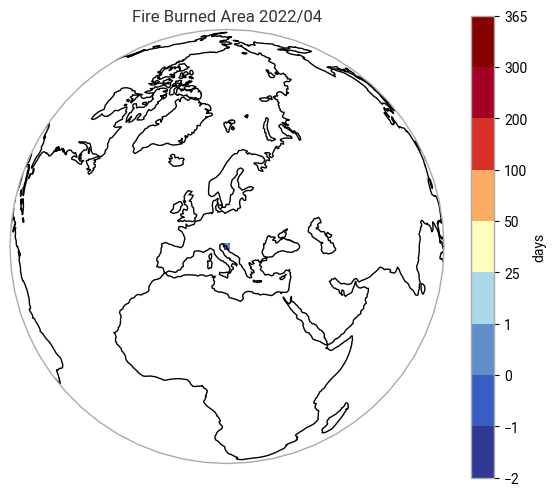

In [20]:
ax = plt.axes(projection=ccrs.Orthographic(15, 45))
ax.set_global()
data_subset_ba_pixel_2D[0].plot(ax=ax, transform=ccrs.PlateCarree(),cmap=cmap, norm=norm )
ax.coastlines()
plt.title(title)
plt.show()

**Figure 6: Map of the day of first detection from the Pixel Burned Area product of April 2022 over SE-Europe - orthographic projection**

## Use case I - Explore C3S & CCI Fire Burned Area dataset over time

**Application main steps:**
- Definition of the time period and download the data
- Define a point based on the latitude and longitude values
- Retrieve the corresponding subset
- Show the time series and save the image

In [ ]:
# Define a download filename:
download_filename_gridded_ts = f"{DATADIR}/ba_grid_2020-2021.zip"

# Downloading ba-pixel product over Europe
dataset = "satellite-fire-burned-area"
request = {
    "origin": "c3s",
    "sensor": "olci",
    "variable": "grid_variables",
    "version": "1_1",
    "year": ["2020", "2021"],
    "month": [
        "02", "04", "06",
        "09", "12"
    ],
    "nominal_day": ["01"]
}

if not os.path.exists(download_filename_gridded_ts):
    c.retrieve(dataset, request, download_filename_gridded_ts)
else:
    print(f"File {download_filename_gridded_ts} already exists. Skipping download.")

ba_grid_data_multiple_years = ek.data.from_source("file", download_filename_gridded_ts)
ba_grid_data_multiple_years

File ./data_dir/ba_grid_2020-2021.zip already exists. Skipping download.


NetCDFMultiFieldList(NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-7bb3d0dce249dcd72931df9baf6d353c85e85cfdac6c4c4a7ec0be6a0f7fb4e8.d/20200201-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-7bb3d0dce249dcd72931df9baf6d353c85e85cfdac6c4c4a7ec0be6a0f7fb4e8.d/20200401-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-7bb3d0dce249dcd72931df9baf6d353c85e85cfdac6c4c4a7ec0be6a0f7fb4e8.d/20200601-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-7bb3d0dce249dcd72931df9baf6d353c85e85cfdac6c4c4a7ec0be6a0f7fb4e8.d/20200901-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-7bb3d0dce249dcd72931df9baf6d353c85e85cfdac6c4c4a7ec0be6a0f7fb4e8.d/20201201-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-7bb3d0dce249dcd72931df9baf6d353c85e85cfdac6c4c4a7ec0be6a0f7fb4e8.d/20210201-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-7bb3d0dce249dcd72931df9baf6d353c85e85cfdac6c4c4a7ec0be6a0f7fb4e8.d/20210401-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-7bb3d0dce249dcd72931df9baf6d353c85e85cfdac6c4c4a7ec0be6a0f7fb4e8.d/20210601-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-7bb3d0dce249dcd72931df9baf6d353c85e85cfdac6c4c4a7ec0be6a0f7fb4e8.d/20210901-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-7bb3d0dce249dcd72931df9baf6d353c85e85cfdac6c4c4a7ec0be6a0f7fb4e8.d/20211201-C3S-L4_FIRE-BA-OLCI-fv1.1.nc))

In [ ]:
# Show the dataset
data_grid=ba_grid_data_multiple_years.to_xarray()
data_grid

<xarray.Dataset> Size: 913MB
Dimensions:                          (time: 10, lat: 720, bounds: 2, lon: 1440,
                                      vegetation_class: 18)
Coordinates:
  * lat                              (lat) float32 3kB 89.88 89.62 ... -89.88
  * lon                              (lon) float32 6kB -179.9 -179.6 ... 179.9
  * time                             (time) datetime64[ns] 80B 2020-02-01 ......
  * vegetation_class                 (vegetation_class) int32 72B 10 20 ... 180
Dimensions without coordinates: bounds
Data variables:
    lat_bounds                       (time, lat, bounds) float32 58kB dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bounds                       (time, lon, bounds) float32 115kB dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    time_bounds                      (time, bounds) datetime64[ns] 160B dask.array<chunksize=(1, 2), meta=np.ndarray>
    vegetation_class_name            (time, vegetation_class) |S150 27kB dask.array<chunksize=(1, 18), meta=np.ndarray>
    burned_area                      (time, lat, lon) float32 41MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    standard_error                   (time, lat, lon) float32 41MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    fraction_of_burnable_area        (time, lat, lon) float32 41MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    fraction_of_observed_area        (time, lat, lon) float32 41MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    burned_area_in_vegetation_class  (time, vegetation_class, lat, lon) float32 746MB dask.array<chunksize=(1, 18, 720, 1440), meta=np.ndarray>
    crs                              (time) int32 40B -2147483647 ... -214748...
Attributes: (12/40)
    title:                      ECMWF C3S Gridded OLCI Burned Area product
    institution:                University of Alcala
    source:                     ESA Sentinel-3 A+B OLCI FR, MODIS MCD14ML Col...
    history:                    Created on 2021-05-13 16:42:16
    references:                 See https://climate.copernicus.eu/
    tracking_id:                6848e827-7c22-4c97-a346-ad8666f5332b
    ...                         ...
    sensor:                     OLCI
    spatial_resolution:         0.25 degrees
    geospatial_lon_units:       degrees_east
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.25
    geospatial_lat_resolution:  0.25

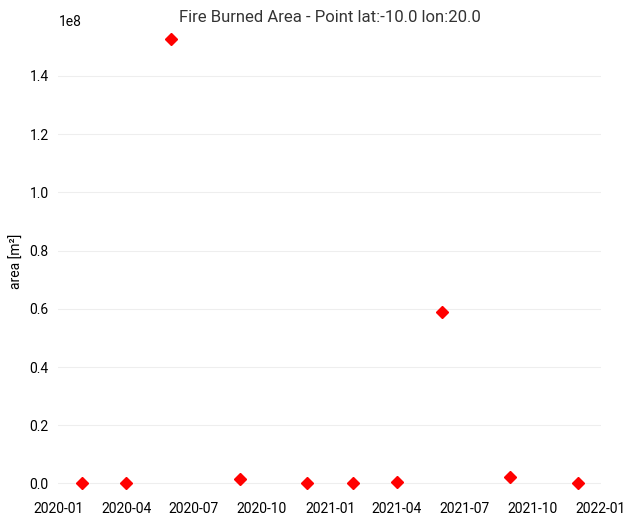

/opt/homebrew/Caskroom/miniforge/base/envs/TM-TESTING/lib/python3.13/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/opt/homebrew/Caskroom/miniforge/base/envs/TM-TESTING/lib/python3.13/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [ ]:
# Point selection 
lon = 20.0
lat = -10.0

data_grid_subset = data_grid.sel(lat=lat, lon=lon, method='nearest')
data_ba_grid_timeseries=data_grid_subset['burned_area']
title = 'Fire Burned Area'
data_ba_grid_timeseries.coords['time'].values
# Create the figure
fig, ax = plt.subplots()
ax.plot(data_ba_grid_timeseries.coords['time'].values, data_ba_grid_timeseries,  marker="D", linestyle='None', color ='red')
ax.set_xlim(np.datetime64('2020-01-01'), np.datetime64('2022-01-01'))
#ax.set_ylim(0, 255)
ax.set_title(title + ' - Point lat:' + str(lat) + ' lon:' + str(lon))
ax.set_ylabel("area [m²]")

# Show figure
plt.show()

**Figure 7: Fire burned area [km²] on a selected location in Angola for February, April,June, September and December of 2020 and 2021**

## Use case II - Create a map of total area burned

**Application main steps:**
- Retrieve burned area data over a defined time range and area, defined by longitude and latitude coordinates
- Calculate the total area burned
- Show the result as a map of the total area burned

In [ ]:
# Define a download filename:
download_filename_gridded_2020 = f"{DATADIR}/ba_grid_2020.zip"

# Downloading ba-pixel product over Europe
dataset = "satellite-fire-burned-area"
request =     {
    "origin": "c3s",
    "sensor": "olci",
    "variable": "grid_variables",
    "version": "1_1",
    "year": ["2020"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "nominal_day": ["01"]
}


if not os.path.exists(download_filename_gridded_2020):
    c.retrieve(dataset, request, download_filename_gridded_2020)
else:
    print(f"File {download_filename_gridded_2020} already exists. Skipping download.")

ba_grid_data_2020 = ek.data.from_source("file", download_filename_gridded_2020)
ba_grid_data_2020


File ./data_dir/ba_grid_2020.zip already exists. Skipping download.


NetCDFMultiFieldList(NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20200101-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20200201-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20200301-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20200401-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20200501-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20200601-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20200701-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20200801-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20200901-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20201001-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20201101-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-423c7f2dee56ab0e556642a27027b75e8a422c561b9f094377adad6f318cc548.d/20201201-C3S-L4_FIRE-BA-OLCI-fv1.1.nc))

In [ ]:
# Show the dataset
data_grid_2020=ba_grid_data_2020.to_xarray()
data_grid_2020

<xarray.Dataset> Size: 1GB
Dimensions:                          (time: 12, lat: 720, bounds: 2, lon: 1440,
                                      vegetation_class: 18)
Coordinates:
  * lat                              (lat) float32 3kB 89.88 89.62 ... -89.88
  * lon                              (lon) float32 6kB -179.9 -179.6 ... 179.9
  * time                             (time) datetime64[ns] 96B 2020-01-01 ......
  * vegetation_class                 (vegetation_class) int32 72B 10 20 ... 180
Dimensions without coordinates: bounds
Data variables:
    lat_bounds                       (time, lat, bounds) float32 69kB dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bounds                       (time, lon, bounds) float32 138kB dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    time_bounds                      (time, bounds) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    vegetation_class_name            (time, vegetation_class) |S150 32kB dask.array<chunksize=(1, 18), meta=np.ndarray>
    burned_area                      (time, lat, lon) float32 50MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    standard_error                   (time, lat, lon) float32 50MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    fraction_of_burnable_area        (time, lat, lon) float32 50MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    fraction_of_observed_area        (time, lat, lon) float32 50MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    burned_area_in_vegetation_class  (time, vegetation_class, lat, lon) float32 896MB dask.array<chunksize=(1, 18, 720, 1440), meta=np.ndarray>
    crs                              (time) int32 48B -2147483647 ... -214748...
Attributes: (12/40)
    title:                      ECMWF C3S Gridded OLCI Burned Area product
    institution:                University of Alcala
    source:                     ESA Sentinel-3 A+B OLCI FR, MODIS MCD14ML Col...
    history:                    Created on 2021-05-13 16:12:01
    references:                 See https://climate.copernicus.eu/
    tracking_id:                1d0af64d-662e-4874-b0a0-c08da1602edc
    ...                         ...
    sensor:                     OLCI
    spatial_resolution:         0.25 degrees
    geospatial_lon_units:       degrees_east
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.25
    geospatial_lat_resolution:  0.25

In [ ]:
# Definition of the color map 

cmap = mcolors.ListedColormap([
    ( 49/256.,  57/256., 149/256.),    # <1         # <5
    ( 57/256.,  94/256., 196/256.),    # 1-5        # 5-10
    ( 96/256., 143/256., 204/256.),    # 5-10       # 10-25
    (171/256., 217/256., 233/256.),    # 10-25      # 25-50
    (255/256., 255/256., 191/256.),    # 25-50      # 50-100
    (253/256., 174/256.,  97/256.),    # 50-100     # 100-250
    (215/256.,  48/256.,  39/256.),    # 100-200    # 250-500
    (165/256.,   0/256.,  38/256.),    # 200-300    # 500-750
    (135/256.,   0/256.,   0/256.),    # >300       # >750
])

bounds = [0.5, 5, 50, 100, 250, 500, 1000, 1500, 2500, 5000]
norm = mcolors.BoundaryNorm(bounds, cmap.N) 

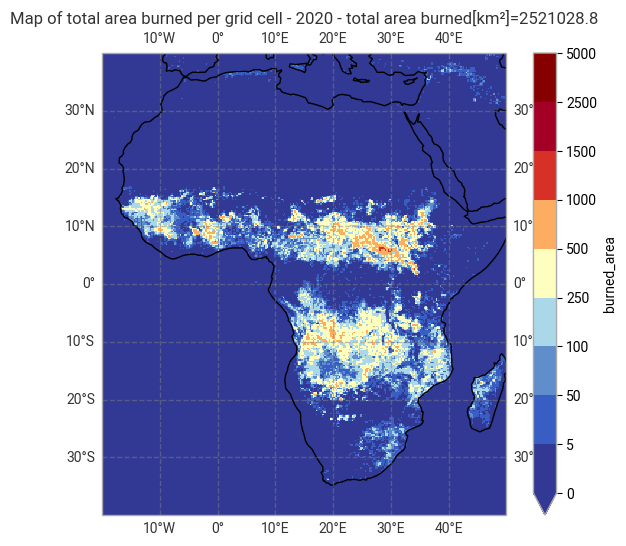

In [ ]:
# Spatial subset selection 
min_lon = -20
min_lat = 40
max_lon = 50
max_lat = -40

data_grid_2020_subset = data_grid_2020.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))    
data_grid_2020_subset_2D=data_grid_2020_subset['burned_area']

# Calculate the total burned area per pixel over the time period
data_grid_2020_subset_2D_sum=data_grid_2020_subset_2D.sum(dim='time', skipna=True)/1000000.

# Calculate the total burned area per pixel over the time period and region
sum_all=math.floor(data_grid_2020_subset_2D_sum.sum(dim=["lat", "lon"], skipna=True)*100.)/100.

# Set plot title		
title = 'Map of total area burned per grid cell - 2020 - total area burned[km²]=' + str(sum_all)

# Create the figure
ax = plt.axes(projection=ccrs.PlateCarree())
fig=data_grid_2020_subset_2D_sum.plot(cmap=cmap, norm=norm)
gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top=False
ax.coastlines()
plt.title(title)
# Show figure
plt.show()

**Figure 8: Map of the total area burned of 2020**

**The C3S and CCI Fire Burned Area products indicate a burned area of around 2,521,029 square kilometres in Africa in 2020.**

## Use case III - Create a map of burned area anomaly

**Application main steps:**
-  Retrieve burned area data of a reference year(s) and over area, defined by longitude and latitude coordinates & calculate mean and standard deviation
-  Retrieve burned area data of selected date and over area, defined by longitude and latitude coordinates
-  Calculate the anomaly of the burned area regarding the reference year(s)
-  Show the result as a map of the anomaly 

In [ ]:
# Definition of the color map 

cmap = mcolors.ListedColormap([
    ( 49/256.,  57/256., 149/256.),    # <1         # <5
    ( 57/256.,  94/256., 196/256.),    # 1-5        # 5-10
    ( 96/256., 143/256., 204/256.),    # 5-10       # 10-25
    (171/256., 217/256., 233/256.),    # 10-25      # 25-50
    (255/256., 255/256., 191/256.),    # 25-50      # 50-100
    (253/256., 174/256.,  97/256.),    # 50-100     # 100-250
    (215/256.,  48/256.,  39/256.),    # 100-200    # 250-500
    (165/256.,   0/256.,  38/256.),    # 200-300    # 500-750
    (135/256.,   0/256.,   0/256.),    # >300       # >750
])

bounds = [0.5, 5, 50, 100, 250, 500, 1000, 1500, 2500, 5000]
norm = mcolors.BoundaryNorm(bounds, cmap.N) 

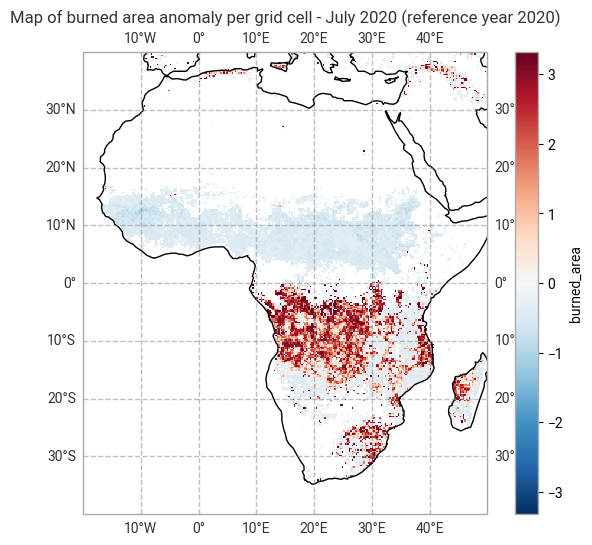

In [ ]:
# Spatial subset selection 
min_lon = -20
min_lat = 40
max_lon = 50
max_lat = -40

data_grid_2020_subset = data_grid_2020.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))    
data_grid_2020_subset_2D=data_grid_2020_subset['burned_area']/1000000.

# Calculate the mean and standard deviation of the burned area per pixel over the time period
data_grid_2020_subset_2D_mean=data_grid_2020_subset_2D.mean(dim='time', skipna=True)
data_grid_2020_subset_2D_std=data_grid_2020_subset_2D.std(dim='time', skipna=True)

# Calculate the anomaly 
anomaly_data = (data_grid_2020_subset_2D-data_grid_2020_subset_2D_mean)/data_grid_2020_subset_2D_std

# Set plot title		
title = 'Map of burned area anomaly per grid cell - July 2020 (reference year 2020)' 

# Create the figure
ax = plt.axes(projection=ccrs.PlateCarree())

fig=anomaly_data[6].plot()
gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top  =False
ax.coastlines()
plt.title(title)
# Show figure
plt.show()

**Figure 9: Map of burned area anomaly per grid cell for July 2020 (reference July 2020)**

**Retrieve the other reference years**


In [ ]:
# Define a download filename:
download_filename_gridded_07_2017_2022 = f"{DATADIR}/ba_grid_07-2017-2022.zip"

# Downloading ba-pixel product over Europe
dataset = "satellite-fire-burned-area"
request = {
    "origin": "c3s",
    "sensor": "olci",
    "variable": "grid_variables",
    "version": "1_1",
    "year": [
        "2017", "2018", "2019",
        "2020", "2021", "2022"
    ],
    "month": ["07"],
    "nominal_day": ["01"]
}


if not os.path.exists(download_filename_gridded_07_2017_2022):
    c.retrieve(dataset, request, download_filename_gridded_07_2017_2022)
else:
    print(f"File {download_filename_gridded_07_2017_2022} already exists. Skipping download.")

ba_grid_data_07_2017_2022 = ek.data.from_source("file", download_filename_gridded_07_2017_2022)
ba_grid_data_07_2017_2022


2025-04-08 14:23:26,979 INFO Request ID is 801f84b2-1e81-45a2-bf4a-9fabdad83b3d
2025-04-08 14:23:27,045 INFO status has been updated to accepted
2025-04-08 14:23:35,459 INFO status has been updated to running
2025-04-08 14:25:21,086 INFO status has been updated to successful


d6d2bfa3473641e2418cfc0974fb6e16.zip:   0%|          | 0.00/522M [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

NetCDFMultiFieldList(NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-617e04ab9ddd444c39ffafed8e20737e5f4e0112841a1c341f73a1e19630aa1d.d/20170701-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-617e04ab9ddd444c39ffafed8e20737e5f4e0112841a1c341f73a1e19630aa1d.d/20180701-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-617e04ab9ddd444c39ffafed8e20737e5f4e0112841a1c341f73a1e19630aa1d.d/20190701-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-617e04ab9ddd444c39ffafed8e20737e5f4e0112841a1c341f73a1e19630aa1d.d/20200701-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-617e04ab9ddd444c39ffafed8e20737e5f4e0112841a1c341f73a1e19630aa1d.d/20210701-C3S-L4_FIRE-BA-OLCI-fv1.1.nc),NetCDFFieldListReader(/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/earthkit-data-edwardcomyn-platt/file-617e04ab9ddd444c39ffafed8e20737e5f4e0112841a1c341f73a1e19630aa1d.d/20220701-C3S-L4_FIRE-BA-OLCI-fv1.1.nc))

In [ ]:
# Show the dataset
data_grid_07_2017_2022=ba_grid_data_07_2017_2022.to_xarray()
data_grid_07_2017_2022

<xarray.Dataset> Size: 548MB
Dimensions:                          (time: 6, lat: 720, bounds: 2, lon: 1440,
                                      vegetation_class: 18)
Coordinates:
  * lat                              (lat) float32 3kB 89.88 89.62 ... -89.88
  * lon                              (lon) float32 6kB -179.9 -179.6 ... 179.9
  * time                             (time) datetime64[ns] 48B 2017-07-01 ......
  * vegetation_class                 (vegetation_class) int32 72B 10 20 ... 180
Dimensions without coordinates: bounds
Data variables:
    lat_bounds                       (time, lat, bounds) float32 35kB dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bounds                       (time, lon, bounds) float32 69kB dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    time_bounds                      (time, bounds) datetime64[ns] 96B dask.array<chunksize=(1, 2), meta=np.ndarray>
    vegetation_class_name            (time, vegetation_class) |S150 16kB dask.array<chunksize=(1, 18), meta=np.ndarray>
    burned_area                      (time, lat, lon) float32 25MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    standard_error                   (time, lat, lon) float32 25MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    fraction_of_burnable_area        (time, lat, lon) float32 25MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    fraction_of_observed_area        (time, lat, lon) float32 25MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    burned_area_in_vegetation_class  (time, vegetation_class, lat, lon) float32 448MB dask.array<chunksize=(1, 18, 720, 1440), meta=np.ndarray>
    crs                              (time) int32 24B -2147483647 ... -214748...
Attributes: (12/40)
    title:                      ECMWF C3S Gridded OLCI Burned Area product
    institution:                University of Alcala
    source:                     ESA Sentinel-3 A+B OLCI FR, MODIS MCD14ML Col...
    history:                    Created on 2020-02-20 10:09:51
    references:                 See https://climate.copernicus.eu/
    tracking_id:                43565b8a-8cfc-4265-833f-979b6b6e9026
    ...                         ...
    sensor:                     OLCI
    spatial_resolution:         0.25 degrees
    geospatial_lon_units:       degrees_east
    geospatial_lat_units:       degrees_north
    geospatial_lon_resolution:  0.25
    geospatial_lat_resolution:  0.25

In [ ]:
# Spatial subset selection 
min_lon = -20
min_lat = 40
max_lon = 50
max_lat = -40

data_grid_07_2017_2022_subset = data_grid_07_2017_2022.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon)) 
data_grid_07_2017_2022_subset_2D=data_grid_07_2017_2022_subset['burned_area']/1000000.

# Calculate the mean and standard deviation of the burned area per pixel over the time period
data_grid_07_2017_2022_subset_2D_mean=data_grid_07_2017_2022_subset_2D.mean(dim='time', skipna=True)
data_grid_07_2017_2022_subset_2D_std=data_grid_07_2017_2022_subset_2D.std(dim='time', skipna=True)

# Calculate the anomaly 
anomaly_data_timeseries = (data_grid_2020_subset_2D-data_grid_07_2017_2022_subset_2D_mean)/data_grid_07_2017_2022_subset_2D_std

In [34]:
anomaly_data_timeseries

<xarray.DataArray 'burned_area' (time: 12, lat: 320, lon: 280)> Size: 4MB
dask.array<truediv, shape=(12, 320, 280), dtype=float32, chunksize=(1, 320, 280), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1kB 39.88 39.62 39.38 39.12 ... -39.38 -39.62 -39.88
  * lon      (lon) float32 1kB -19.88 -19.62 -19.38 -19.12 ... 49.38 49.62 49.88
  * time     (time) datetime64[ns] 96B 2020-01-01 2020-02-01 ... 2020-12-01

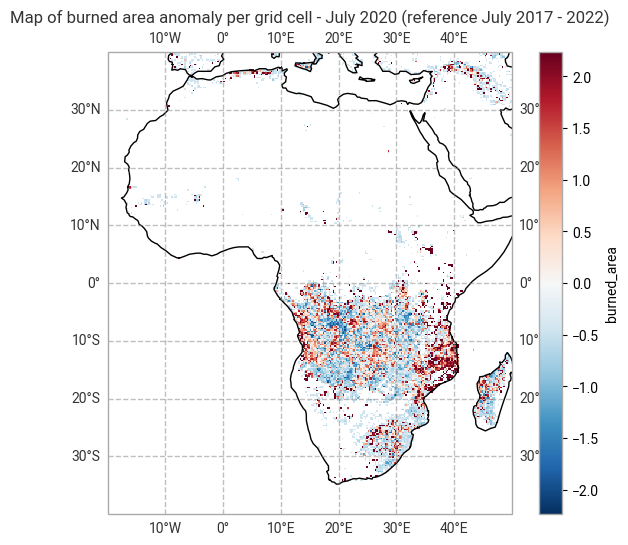

In [ ]:
# Set plot title		
title_anomaly = 'Map of burned area anomaly per grid cell - July 2020 (reference July 2017 - 2022)' 

# Create the second figure
ax = plt.axes(projection=ccrs.PlateCarree())

fig=anomaly_data_timeseries[6].plot()
gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False
ax.coastlines()
plt.title(title_anomaly)
# Show figure
plt.show()

**Figure 10: Map of burned area anomaly per grid cell for July 2020 (reference July 2017 - 2022)**

**The anomaly map for July shows that more burned area was observed in the south in July 2020 compared to the mean value for 2020 as expected. Additionally, the anomaly map comparing July 2020 to the mean July values from 2017 to 2022 reveals variations in both directions, indicating some areas with more and others with less burned area than the multi-year July average.**


## Take home messages 📌

This tutorial demonstrated how C3S & CCI Fire Burned Area products available through the C3S can be explored. By working on a spatial and temporal statistics of the area burned we produced information on Africa's total area burned. We have downloaded, visualised, subset, and analysed the data, to produce meaningful and informative visuals. In addition, we derived and visualised an additional aspect - burned area anomaly - from the data.